# Drift and Diffusion in XENON1T


La forma degli eventi S2 è determinata da 3 parametri: **drift velocity**, **diffusion constant** e **SPE waveform model**. Qui ci concentriamo sui primi 2 parametri.

## Drift Velocity

Viene calcolato dalla differenza dei centri di S1 e the S2 ed è contenuto in `event_basics`. 

In [1]:
import os
import numpy as np
import pandas as pd
import drift_diffusion as dd

In [2]:
count = 0
fnames = []
for p, d, files in os.walk(os.getcwd()):
    d.sort()
    for f in sorted(files):
        if f.endswith(".h5"):
            fnames.append(f)
            count+=1
if count>0:
    print('Data file n.',count)
    print(fnames)

Data file n. 5
['data_170204_1410-170205_0012.h5', 'data_170204_1410-170621_0617.h5', 'data_170205_0012-170205_1013.h5', 'data_170205_1013-170205_2015.h5', 'data_170205_2015-170206_0617.h5']


In [3]:
data = pd.read_hdf('data_170204_1410-170621_0617.h5', 'data')

In [4]:
# to open data from contexts
import straxen
st = straxen.contexts.xenon1t_dali()
runs = st.select_runs(available='event_info',run_mode='background_stable')

Checking data availability: 100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


In [ ]:
data = select_data_from_runs( runs,len(runs))

/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity determined at 1.339 km/s


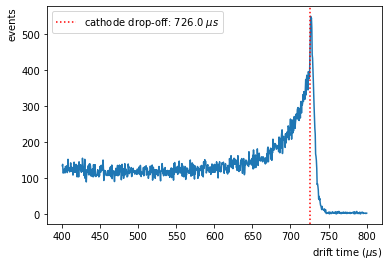

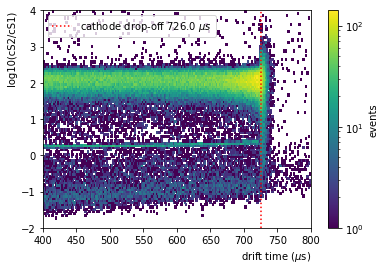

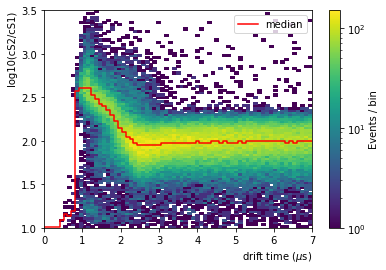

In [4]:
vd = dd.drift_velocity(data,True)

### Drift Time

Il massimo nello spettro del drift time è legato a eventi che avvengono al catodo; il rate di eventi aumenta scendendo nella TPC, dato che la schermo di xenon (da gamma provenienti da materiali sotto la TPC) si riduce sempre di più; fino a diminuire improvvisamente dato che S2 non possoono essere collezionati da sotto il catodo.

### S2/S1 Ratio
* **low S2/S1 events**, sono prodotti da electron clouds che si trovano nella regione di inversione del campo al catodo, parte della carica va verso il bottom screen e non risale all'anodo
* **large S2s** sono prodotti in regione con alto campo vicino i fili del catodo; questo sopprime l'effetto di ricombinazione delle coppie, aumentando quindi S2

### Drift time of gate events

Gli eventi creati al gate non sono visibili a tempi più bassi, questi eventi possono essere generati anche nel sottile strato tra il gate e l'anodo.

A tempi sotto i 3 $\mu$s il rapporto $cS1/cS2$ sale, questo è dovuto al fatto che il campo elettrico cresce passando il gate sopprimento l'effetto di ricombinazione e quindi aumentando S2 a discapito di S1.

La posizione orientativo del gate è dove c'è il rapido cambio intorno a 1.5$~\mu$s.

## Diffusion Constant

### Richiamo di teoria

The diffusion constant $D$ describes the diffusive broadening of electron clouds, and eventually the S2 signals, with increasing drift time.

Non ci sono molti lavori a riguardo, si prende come riferimento quello di [Sorensen](https://arxiv.org/abs/1102.2865) che definisce la devisione standard del segnale S2 (per un infinitely thin gas gap):

\begin{equation}
\sigma = \frac{\sqrt{2 D t}}{v}
\end{equation}
il numeratore è la larghezza longitudinale dell'electron cloud con $t$ the drift time, $v$ è la drift velocity. 

Per $t$ lunghi ($>30\mu$s per Sorensen), la diffusione rende la forma di S2 ancora una gaussiana approssimata, si usa una versione modificata dell'equazionee:

\begin{equation}
\sigma = \sqrt{\frac{2 D t}{v^2} + {\sigma_0}^2}
\end{equation}
dove $\sigma_0$ è una costante da settare; se la risposta al SPE fosse una gaussiana perfetta, $\sigma_0$ sarebbe la larghezza di very shallow S2s.

Viene utilizzata l'area al 50% area $r_{50}$ per misurare la larghezza di S2, in modo da evitare la coda. Facendo l'aprossimazione di gaussiana $r_{50} \approx 1.349 \sigma$ si può scrivere:

\begin{equation}
r_{50} = \sqrt{\frac{3.6395 D t}{v^2} + {w_0}^2}
\end{equation}

### S2 width vs energy
la larghezza dipende dall'energia per 2 effetti:

* i segnali S2 hanno una certa distribuzione per la width dovuta al numero finito di elettroni, a **bassa statistica** gli stimatori della larghezza non sono molto corretti;
* al contrario, per gli S2 ad **alte energie** c'è la saturation dell'ADC, che taglia parte dell'area e questo provoca un aumento della larghezza (con S2 ~ 30k PE) (vedere meglio questa cosa)

Computing likelihoods: 12527it [01:02, 231.90it/s]                           

Diffusion constant = 31.05 +/- 13.47 cm^2/s 


/home/valerio/Dropbox/Ricerca/PostDocXenon/1.Analysis/xenon-notes/drift_diffusion/drift_diffusion.py:203: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('diffusion_constant.png')


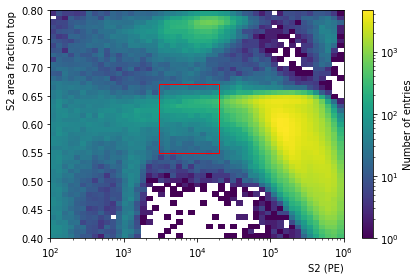

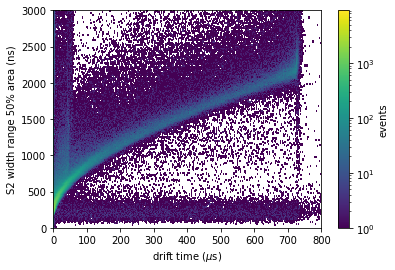

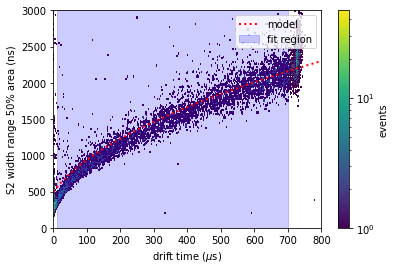

Computing likelihoods: 12550it [01:20, 231.90it/s]

In [5]:
s2_bounds = (3e3, 2e4)
aft_bounds = (0.55, 0.67)
fit_range = (10, 700)
d_const, d_const_err = dd.diffusion_constant(data,s2_bounds,aft_bounds,fit_range,vd,True)

### Taglio su S2 e S2 area fraction top (AFT)

AFT diminuisce ad alte energia: questo anche è dovuto alla saturazione nel top array. Jelle utilizza i tagli mostrati nel grafico: s2[10k:20k] e AFT[0.55:0.7].
Il taglio su S2 rimuove:
* eventi di alta energia dove si ha la saturazione dell'ADC (e questo allarga artificialmente S2-width)
* eventi di bassa energia dove non vale l'equazione della diffusione per la statistica bassa

Il taglio sulla frazione vista dai PMT in alto (S2_AFT) rimuove:
* eventi che avvengono nelle vicinanze del top array (o nel gas) che hanno un `drift time` breve e una larghezza maggiore

### Fit per determinare the Diffusion Constant
Per fare il fit vengono usati soltanto tempi tra 50 e 350 us:
* in basso per garantire che S2 abbia una distribuzione guassiana
* in alto per rimuovere eventi ad alta statistica che producono eventi anomali

## Adamento nel tempo (dividendo i dati in più file)

In [ ]:
veld = np.zeros(count)
diff = np.zeros(count)
for i in range(count):
    data = pd.read_hdf(fnames[i], 'data')
    veld[i] = dd.drift_velocity(data)
    diff[i] = dd.diffusion_constant(data,s2_bounds,aft_bounds,fit_range,vd)

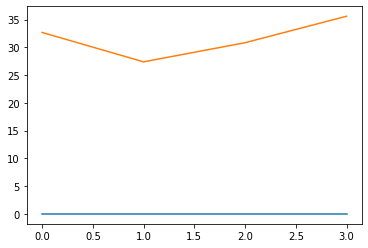

In [11]:
import matplotlib.pyplot as plt
plt.plot(veld)
plt.plot(diff)